In [61]:
# Deep
deep = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00075-cavity_check_2024-12-12T171954'
# Tiny
tiny = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00032-cavity_check_2024-12-12T144742'
# Good
good = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00077-cavity_check_2024-12-12T172355'
# Bad
bad = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00062-cavity_check_2024-12-12T160601'
# Very bad
very_bad = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00053-cavity_check_2024-12-12T155026'

In [62]:
"""
Fit the refrection data of cavity

Reference:
Gao's thesis,
Efficient and robust analysis of complex scattering data under noise in
microwave resonators, by S.Probst et al.

"""
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize, newton
# import seaborn as sns
import csv
# sns.set()
# colors = sns.color_palette("hls", 12)
# sns.set(palette="tab10")
# sns.set_context("notebook")
# sns.set_style("whitegrid")
# sns.set_style("ticks")

###################################################################################################
path = good
filename = path+r"\data.ddh5"
h5file = h5py.File(filename,"r")
# # ZI instrument
# data = h5file["data"]["data"][0]
# freq= h5file["data"]["ro_freq"][0]

# VNA
dBmag = h5file["data"]["mag"][0]
phase = h5file["data"]["phase"][0]
data = 10**(dBmag/20)*np.exp(1j*phase)
freq = h5file["data"]["frequency"][0]

# cut the data
data_cut=data[:]
freq_cut=freq[:]

# # cut the data
# data_cut=np.hstack((data[0:400],data[650:1001]))
# freq_cut=np.hstack((freq[0:400],freq[650:1001]))

measurement = "Reflection_S11" # "Reflection_S11" or "Reflection_S21"
###################################################################################################

markersize=1.5
fit_npts = 6000

def circle_fit(linmag, uwphase):
    """
    Fit the complex data to a circle.
    Fitting parameters are the center position and the radius.
    The fitting protocol is written in "Gao's thesis"

    Parameters
    ----------
    linmag:
        array of linear magnitude
    uwphase:
        array of unwrapped phase

    Returns
    -------
    x_circle, y_circle :
        center position of the circle
    r_circle :
        radius of the circle
    """
    data = linmag * np.exp(1j*uwphase)
    x = np.real(data)
    y = np.imag(data)
    z = np.abs(data)

    # stupid guess
    x_circle = (np.max(x)+np.min(x))/2
    y_circle = (np.max(y)+np.min(y))/2
    r_circle = np.average([np.max(x)-np.min(x),np.max(y)-np.min(y)])/2

    # function to be minimized
    def func(xlist):
        x_circle = xlist[0]
        y_circle = xlist[1]
        r_circle = xlist[2]
        return np.sum(np.abs(r_circle**2-(x-x_circle)**2-(y-y_circle)**2))
    # minimize the "func"
    res = minimize(fun=func,
                    x0 = [x_circle, y_circle, r_circle], # initial value
                    method = "Nelder-Mead",
                    jac = False,
                    options={"maxiter":3000000}, # maximum of iteration
                    )
    x_circle, y_circle, r_circle = res.x

    # M = np.array([
    # [np.dot(z,z), np.dot(x,z), np.dot(y,z), np.sum(z)],
    # [np.dot(x,z), np.dot(x,x), np.dot(x,y), np.sum(x)],
    # [np.dot(y,z), np.dot(x,y), np.dot(y,y), np.sum(y)],
    # [np.sum(z), np.sum(x), np.sum(y), len(x)]
    # ])
    # B = np.array([
    # [0,0,0,-2],
    # [0,1,0,0],
    # [0,0,1,0],
    # [-2,0,0,0]
    # ])

    # # function to be minimize
    # def func(mu):
    #     return np.linalg.det(M-mu*B)
    # # minimize the "func"
    # res = minimize(fun=func,
    #                x0 = [0], # initial value
    #                method = "Nelder-Mead",
    #                jac = False,
    #                options={"maxiter":3000000}, # maximum of iteration
    #                )
    # mu = res.x[0]
    # print(
    # "-----------------------------------------\n" \
    # +"Circle fitting finished.\n" \
    # +f"fitted parameter : mu = {mu}\n" \
    # +"number of iteration : "+f"{str(res.nit)}\n" \
    # )

    # # culculate A, B, C, and D
    # A, B, C, D = np.linalg.solve(
    #                             a = M-mu*B,
    #                             b = [0,0,0,0],
    #                             )
    # print(
    # "-----------------------------------------\n" \
    # +f"A={A}, B={B}, C={C}, D={D}\n"
    # )

    # # culculate the center and the radius of the circle
    # x_circle = -B/2/A
    # y_circle = -C/2/A
    # r_circle = 1/2/np.abs(A)
    print(
    "-----------------------------------------\n" \
    +f"center position of the circle : (x, y) = ({x_circle}, {y_circle})\n" \
    +f"radius of the circle : r = {r_circle}\n"
    )

    return x_circle, y_circle, r_circle

def shift_phase(uwphase):
    """
    Shift the unwrapped phase data for the first phase data to be placed
    between -pi and pi.
    """
    n=0
    if uwphase[0]>np.pi:
        while (uwphase[0]-2*n*np.pi)>np.pi:
            n=n+1
    elif uwphase[0]<=-np.pi:
        while (uwphase[0]-2*n*np.pi)<=-np.pi:
            n=n-1

    return uwphase - 2*n*np.pi

def guess_cable_delay(freq, uwphase):
    """
    Roughly guess the cable delay term.
    Calculate the average slope of the uwphase data.

    Parameters
    ----------
    freq:
        array of frequency [Hz]
    uwphase:
        array of unwrapped phase

    Returns
    -------
    rough_tau:
        roughly estimated cable delay [s]
    fitting:
        fitted line
    """

    def linear_phase(freq, tau, theta_0):
        return 2*np.pi*tau*freq + theta_0

    # simple guess
    idx = len(uwphase) // 10 #-1
    rough_tau = (uwphase[idx]-uwphase[0])/(freq[idx]-freq[0])/2/np.pi
    theta_0 = uwphase[0]-2*np.pi*rough_tau*freq[0]

    freq_fit = np.linspace(freq[0],freq[idx],fit_npts)
    fitting = linear_phase(freq_fit,
                           rough_tau,
                           theta_0)
    print(
    "-----------------------------------------\n" \
    +f"rough_tau [s] : {rough_tau}\n"\
    +f"theta_0 : {theta_0}\n"
          )
    return rough_tau, theta_0, freq_fit, fitting

def fit_cable_delay(freq, linmag, uwphase, rough_tau,
                    x_circle, y_circle, r_circle):
    """
    Fine fitting for the cable delay term
    by fitting complex data to pure circle.

    Parameters
    ----------
    data:
        complex data
    rough_tau:
        first estimation of tau

    Returns
    -------
    fine_tau:
        fine fitted tau
    """
    # definition of minimized function
    def func(tau):
        linmag_temp = linmag
        uwphase_temp = uwphase-2*np.pi*tau*(freq-freq[0])
        x_array = linmag_temp*np.cos(uwphase_temp)
        y_array = linmag_temp*np.sin(uwphase_temp)
        a = np.array(
        [np.abs(r_circle**2-(x_i-x_circle)**2-(y_i-y_circle)**2) \
        for x_i, y_i in zip(x_array, y_array)]
        )
        return np.sum(a)
    # minimize the "func"
    res = minimize(fun=func,
                   x0 = [0], # initial value
                   method = "Nelder-Mead",
                   jac = False,
                   bounds=[(-np.abs(rough_tau), np.abs(rough_tau))],
                   options={"maxiter":3000000, # maximum of iteration
                            # "xatol":1e-20,
                            "disp":True},
                   )
    fine_tau = res.x[0]
    print(
    "-----------------------------------------\n" \
    +f"fine tau [s] : {fine_tau}\n" \
    )
    return fine_tau

def fit_phase_vs_freq(freq,uwphase):
    """
    fit phase data and decide the offset phase, Q_total
    and the resonance frequence f_r

    Parameters
    ----------
    freq:
        array of frequency [Hz]
    uwphase:
        array of unwrapped phase

    Returns
    -------
    theta_0:
        offset phase [radian]
    Q_tot:
        total quality factor
    f_r:
        resonance frequency [Hz]
    fitting:
        fitted line
    """
    # # definition of the function to be fitted
    # def func(f, theta_0, Q_tot, f_r):
    #     return theta_0+2*np.arctan(2*Q_tot*(1-f/f_r))

    # define first guess
    theta_0 = np.average(uwphase)
    Q_tot = 0
    f_r = np.average(freq)

    # fit to the func to unwrap phase data
    # popt, pcov = curve_fit(
    #                       f=func,
    #                       xdata=freq,
    #                       ydata=uwphase,
    #                       p0=[theta_0, Q_tot, f_r],
    #                       )
    # theta_0, Q_tot, f_r = popt

    def func(x):
        theta_0, Q_tot, f_r = x
        return np.sum((uwphase-(theta_0+2*np.arctan(2*Q_tot*(1-freq/f_r))))**2)
    res = minimize(fun=func,
                   x0 = [theta_0, Q_tot, f_r], # initial value
                   method = "Nelder-Mead",
                   jac = False,
                   options={"maxiter":3000000, # maximum of iteration
                            # "xatol":1e-15,
                            "disp":True},
                   )
    theta_0, Q_tot, f_r = res.x
    freq_fit = np.linspace(freq[0],freq[-1],fit_npts)
    # fitting = func(freq_fit,
    #                theta_0, Q_tot, f_r)
    fitting = theta_0+2*np.arctan(2*Q_tot*(1-freq_fit/f_r))
    return theta_0, Q_tot, f_r, freq_fit, fitting

def S11_refrection(freq,a,alpha,tau,Q_tot,Q_ext,f_r,phi):
    env=a*np.exp(1j*alpha)*np.exp(2j*np.pi*(freq-freq[0])*tau)
    resonator=1-2*Q_tot/np.abs(Q_ext)*np.exp(1j*phi)/(1+2j*Q_tot*(freq/f_r-1))
    return env*resonator

def S21_refrection_taketo(freq,a,alpha,tau,Q_tot,Q_ext,f_r,phi):
    env=a*np.exp(1j*alpha)*np.exp(2j*np.pi*(freq-freq[0])*tau)
    resonator=1-Q_tot/np.abs(Q_ext)*np.exp(1j*phi)/(1+2j*Q_tot*(freq/f_r-1))
    return env*resonator

# Marco
def S21_refrection(f, a, alpha, t, Q_L, Q_e, f_0, phi):
    env = (a) * np.exp(1j*alpha) *np.exp(-2j*np.pi*(f-f[0])*t)
    resonator = 1 - Q_L * np.exp(1j*phi) / np.abs(Q_e) / (1 + 2j * Q_L * (f - f_0) / f_0)
    return env*resonator

# def s21_transmission(freq, tau, Q_tot, f_r, Cx, Cy):
    # cable_delay=np.exp(2j*np.pi*(freq-freq[0])*tau)
    # resonator=1/(1+2j*Q_tot*(freq/f_r-1))
    # return (Cx+1j*Cy)*cable_delay*resonator

In [63]:
# MAIN PART!!!!!!!!!!!!!!!!!!!!!!!!!
# prepare the data
linmag0 = np.abs(data_cut) # linear scale
uwphase0 = shift_phase(np.unwrap(np.angle(data_cut))) # unwrapped radian

-----------------------------------------
rough_tau [s] : -1.7931480020758977e-10
theta_0 : 9.327516678463798



(np.float64(-0.4065840492457034),
 np.float64(0.9635683342974146),
 np.float64(-0.4356888380337984),
 np.float64(0.939955366709765))

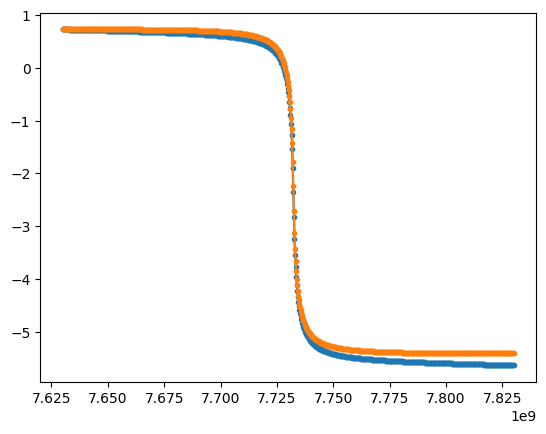

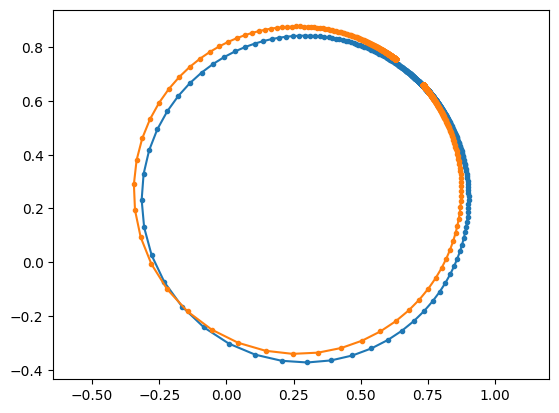

In [64]:
## PART 1: rough guess of cable delay"tau"
rough_tau, theta_0, freq_fit, fitting=guess_cable_delay(freq_cut, uwphase0)

linmag1 = linmag0
uwphase1 = shift_phase(uwphase0-2*np.pi*rough_tau*(freq_cut-freq_cut[0]))

plt.figure()
plt.plot(freq_cut, uwphase0, '.-')
plt.plot(freq_cut, uwphase1, '.-')

plt.figure()
d0 = linmag0*np.exp(1j*uwphase0)
d = linmag1*np.exp(1j*uwphase1)
plt.plot(np.real(d0), np.imag(d0), '.-')
plt.plot(np.real(d), np.imag(d), '.-')
plt.axis('equal')

-----------------------------------------
center position of the circle : (x, y) = (0.26506548684899356, 0.2680124168558461)
radius of the circle : r = 0.6094433191290822

Optimization terminated successfully.
         Current function value: 0.170297
         Iterations: 10
         Function evaluations: 20
-----------------------------------------
fine tau [s] : 3.5022421915544876e-13



(np.float64(-0.4052316476896242),
 np.float64(0.9351679016197522),
 np.float64(-0.4020662820738749),
 np.float64(0.9383542926164352))

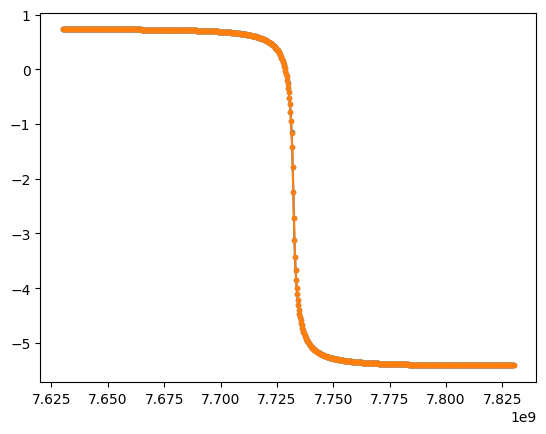

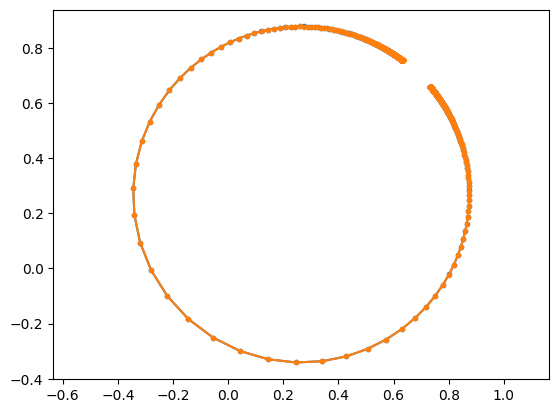

In [65]:
## PART 2: fine guess of cable delay"tau"
x_circle2, y_circle2, r_circle2=circle_fit(linmag1, uwphase1)
fine_tau=fit_cable_delay(freq_cut, linmag1, uwphase1, rough_tau,
                    x_circle2, y_circle2, r_circle2)

linmag2 = linmag1
uwphase2 = shift_phase(uwphase1-2*np.pi*fine_tau*(freq_cut-freq_cut[0]))


plt.figure()
plt.plot(freq_cut, uwphase1, '.-')
plt.plot(freq_cut, uwphase2, '.-')

plt.figure()
d0 = linmag2*np.exp(1j*uwphase1)
d = linmag2*np.exp(1j*uwphase2)
plt.plot(np.real(d0), np.imag(d0), '.-')
plt.plot(np.real(d), np.imag(d), '.-')
plt.axis('equal')

PART 3
-----------------------------------------
center position of the circle : (x, y) = (0.26509033907406704, 0.26796245563322996)
radius of the circle : r = 0.6094520096072371



(np.float64(-0.6848594512424464),
 np.float64(0.9768195439163072),
 np.float64(-0.6817214892399681),
 np.float64(0.9159396191733319))

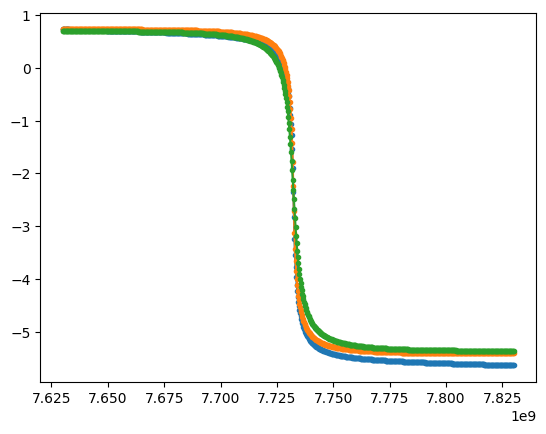

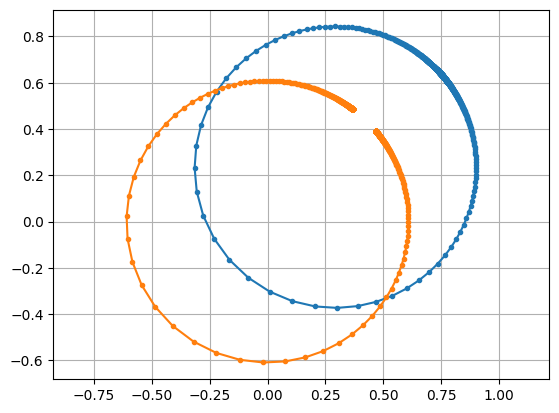

In [66]:
## PART 3: circle fit and move to the origin
print('PART 3')
# plt.figure()
# plt.plot(np.real(linmag2 * np.exp(1j*uwphase2)), np.imag(linmag2 * np.exp(1j*uwphase2)))
# plt.axis('equal')
# plt.grid()
# plt.show()

x_circle3, y_circle3, r_circle3=circle_fit(linmag2, uwphase2)

data3=linmag2*np.exp(1j*uwphase2)-(x_circle3+1j*y_circle3)
linmag3 = np.abs(data3)
uwphase3 = shift_phase(np.unwrap(np.angle(data3)))



plt.figure()
plt.plot(freq_cut, uwphase0, '.-')
plt.plot(freq_cut, uwphase2, '.-')
plt.plot(freq_cut, uwphase3, '.-')

plt.figure()
d0 = linmag0*np.exp(1j*uwphase0)
d = linmag3*np.exp(1j*uwphase3)
plt.plot(np.real(d0), np.imag(d0), '.-')
plt.plot(np.real(d), np.imag(d), '.-')
plt.grid()
plt.axis('equal')

In [67]:
## PART 4: phase VS freq fit. Decide Q_total and f_r
print('PART 4')
theta_0, Q_tot, f_r, freq_fit, fitting=fit_phase_vs_freq(freq_cut,uwphase3)
# plot the data
p1 = (x_circle3+1.1*r_circle3, y_circle3)
p2 = (x_circle3+1.1*r_circle3*np.cos(theta_0), y_circle3+1.1*r_circle3*np.sin(theta_0))

theta_0, Q_tot, f_r

PART 4
Optimization terminated successfully.
         Current function value: 0.895593
         Iterations: 399
         Function evaluations: 735


(np.float64(-2.332401770988384),
 np.float64(1377.778034210285),
 np.float64(7732285934.875877))

PART 5
0.9863432827669105 0.8021578653392015


(np.float64(-0.3810136732187607),
 np.float64(1.0626114243939733),
 np.float64(-0.6948295826944462),
 np.float64(0.9165638140997356))

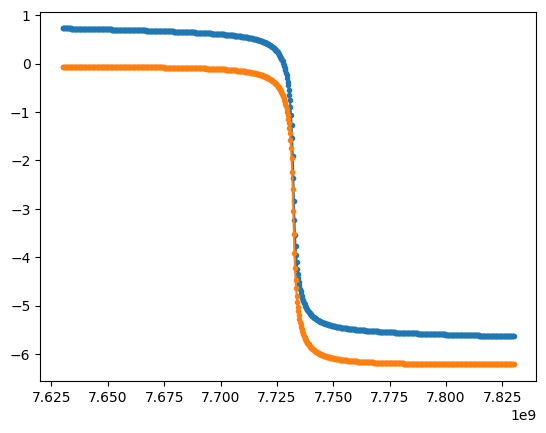

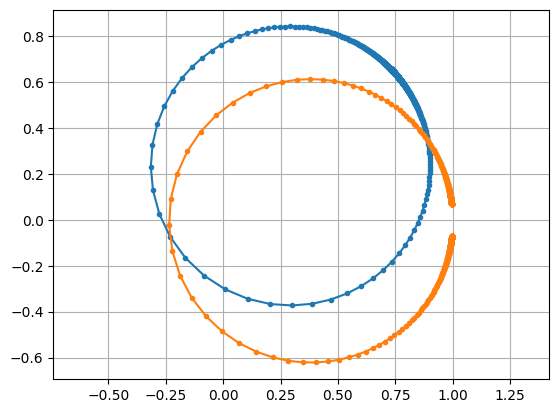

In [68]:
## PART 5: calculate off-resonance point and decide a and alpha
print('PART 5')
p_offres=(x_circle3+1j*y_circle3)+r_circle3*np.exp(1j*(theta_0+np.pi))
a = np.abs(p_offres)
alpha = np.angle(p_offres)

print(a, alpha)

linmag5 = linmag2/a
uwphase5 = uwphase2-alpha

plt.figure()
plt.plot(freq_cut, uwphase0, '.-')
plt.plot(freq_cut, uwphase5, '.-')

plt.figure()
d0 = linmag0*np.exp(1j*uwphase0)
d = linmag5*np.exp(1j*uwphase5)
plt.plot(np.real(d0), np.imag(d0), '.-')
plt.plot(np.real(d), np.imag(d), '.-')
plt.grid()
plt.axis('equal')

In [69]:
## PART 6: circle fit and decide impedance mismatch and Q external
print('PART 6')
x_circle6, y_circle6, r_circle6=circle_fit(linmag5, uwphase5)
phi_mismatch=-np.arcsin(y_circle6/r_circle6)
if measurement=="Reflection_S21":
    Q_ext=Q_tot/(2*r_circle6*np.exp(-1j*phi_mismatch))
elif measurement=="Reflection_S11":
    Q_ext=Q_tot/(r_circle6*np.exp(-1j*phi_mismatch))
Q_int=1/(1/Q_tot-1/np.real(Q_ext))

print(
"-----------------------------------------\n" \
+f"Q_total : {Q_tot}\n" \
+f"Q_external : {Q_ext}\n" \
+f"Q_internal : {Q_int}\n" \
+f"resonance freq [Hz] : {f_r}\n" \
+f"kappa_tot/2pi [Hz] : {f_r/Q_tot}\n" \
+f"kappa_external/2pi [Hz] : {f_r/np.real(Q_ext)}\n" \
+f"kappa_internal/2pi [Hz] : {f_r/Q_int}\n" \
+f"Phi (Impedance mismatch) : {phi_mismatch}\n"
)

if measurement=="Reflection_S21":
    data6=S21_refrection(freq_cut,a,alpha,rough_tau+fine_tau,Q_tot,Q_ext,f_r,phi_mismatch)
elif measurement=="Reflection_S11":
    data6=S11_refrection(freq_cut,a,alpha,rough_tau+fine_tau,Q_tot,Q_ext,f_r,phi_mismatch)

tau = rough_tau+fine_tau
theta_0 = uwphase0[0]-np.unwrap(np.angle(data6))[0]

PART 6
-----------------------------------------
center position of the circle : (x, y) = (0.3820925925259998, -0.00400343308915947)
radius of the circle : r = 0.6179399071819187

-----------------------------------------
Q_total : 1377.778034210285
Q_external : (2229.584305818359+14.445059808573063j)
Q_internal : 3606.3039030897476
resonance freq [Hz] : 7732285934.875877
kappa_tot/2pi [Hz] : 5612141.9727146905
kappa_external/2pi [Hz] : 3468039.2729252623
kappa_internal/2pi [Hz] : 2144102.699789427
Phi (Impedance mismatch) : 0.006478722363365638



In [70]:
## Part7: cable delay fitting (2nd)
print(tau, theta_0)
def func(x):
    tau, theta_0=x
    if measurement=="Reflection_S21":
        data_temp=S21_refrection(freq_cut,a,alpha,tau,Q_tot,Q_ext,f_r,phi_mismatch)
    elif measurement=="Reflection_S11":
        data_temp=S11_refrection(freq_cut,a,alpha,tau,Q_tot,Q_ext,f_r,phi_mismatch)
    uwphase_temp=shift_phase(np.unwrap(np.angle(data_temp)))
    return np.sum((uwphase0-uwphase_temp-theta_0)**2)
# minimize the "func"
res = minimize(fun=func,
               x0 = [tau, theta_0], # initial value
               method = "Nelder-Mead",
               jac = False,
               options={"maxiter":3000000}, # maximum of iteration
               )
tau, theta_0 = res.x


tau, theta_0

-1.789645759884343e-10 -0.037223402011657525


(np.float64(-1.2509451414663212e-10), np.float64(-0.033842988389463126))

-----------------------------------------
center position of the circle : (x, y) = (0.2739649672127034, 0.25824236632168446)
radius of the circle : r = 0.6090609582456581



(np.float64(-0.6832736447363016),
 np.float64(0.9767440293207765),
 np.float64(-0.6801634010517484),
 np.float64(0.9158654244977024))

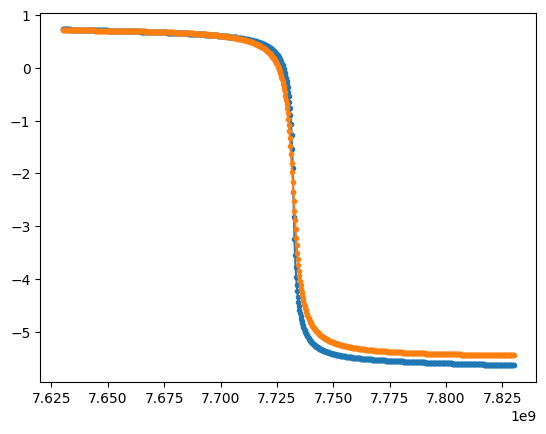

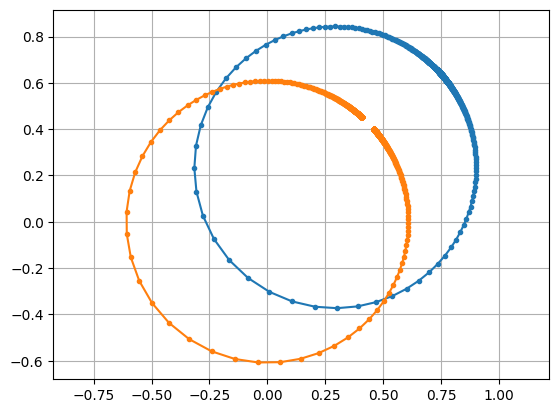

In [71]:
## Part8: repeat from 3 to 6
linmag2 = linmag0
uwphase2 = shift_phase(uwphase0-2*np.pi*tau*(freq_cut-freq_cut[0]))

# 3": circle fit and move to the origin
x_circle3, y_circle3, r_circle3=circle_fit(linmag2, uwphase2)

data3=linmag2*np.exp(1j*uwphase2)-(x_circle3+1j*y_circle3)
linmag3 = np.abs(data3)
uwphase3 = shift_phase(np.unwrap(np.angle(data3)))


plt.figure()
plt.plot(freq_cut, uwphase0, '.-')
plt.plot(freq_cut, uwphase3, '.-')

plt.figure()
d0 = linmag0*np.exp(1j*uwphase0)
d = linmag3*np.exp(1j*uwphase3)
plt.plot(np.real(d0), np.imag(d0), '.-')
plt.plot(np.real(d), np.imag(d), '.-')
plt.grid()
plt.axis('equal')

In [72]:
# 4": phase VS freq fit. Decide Q_total and f_r
theta_0, Q_tot, f_r, freq_fit, fitting=fit_phase_vs_freq(freq_cut,uwphase3)
# plot the data
center = (x_circle3, y_circle3)
p1 = (x_circle3+1.1*r_circle3, y_circle3)
p2 = (x_circle3+1.1*r_circle3*np.cos(theta_0), y_circle3+1.1*r_circle3*np.sin(theta_0))

theta_0, Q_tot, f_r

Optimization terminated successfully.
         Current function value: 0.009709
         Iterations: 410
         Function evaluations: 724


(np.float64(-2.365511407244726),
 np.float64(1427.0334176770991),
 np.float64(7732281892.856205))

In [73]:
# 5": calculate off-resonance point and decide a and alpha
p_offres=(x_circle3+1j*y_circle3)+r_circle3*np.exp(1j*(theta_0+np.pi))
a = np.abs(p_offres)
alpha = np.angle(p_offres)

linmag5 = linmag2/a
uwphase5 = uwphase2-alpha

a, alpha

(np.float64(0.9855050086697862), np.float64(0.7683583122221922))

In [74]:

# 6": circle fit and decide impedance mismatch and Q external
x_circle6, y_circle6, r_circle6=circle_fit(linmag5, uwphase5)
phi_mismatch=-np.arcsin(y_circle6/r_circle6)
if measurement=="Reflection_S21":
    Q_ext=Q_tot/(2*r_circle6*np.exp(-1j*phi_mismatch))
elif measurement=="Reflection_S11":
    Q_ext=Q_tot/(r_circle6*np.exp(-1j*phi_mismatch))
Q_int=1/(1/Q_tot-1/np.real(Q_ext))

-----------------------------------------
center position of the circle : (x, y) = (0.3819916465471739, -0.004777290547872519)
radius of the circle : r = 0.6180314982046113



In [75]:
print(
"-----------------------------------------\n" \
+f"Q_total : {Q_tot}\n" \
+f"Q_external : {Q_ext}\n" \
+f"Q_internal : {Q_int}\n" \
+f"resonance freq [Hz] : {f_r}\n" \
+f"kappa_tot/2pi [Hz] : {f_r/Q_tot}\n" \
+f"kappa_external/2pi [Hz] : {f_r/np.real(Q_ext)}\n" \
+f"kappa_internal/2pi [Hz] : {f_r/Q_int}\n" \
+f"Phi (Impedance mismatch) : {phi_mismatch}\n"
)

-----------------------------------------
Q_total : 1427.0334176770991
Q_external : (2308.928894646671+17.848206390796335j)
Q_internal : 3736.1782407857054
resonance freq [Hz] : 7732281892.856205
kappa_tot/2pi [Hz] : 5418430.848972467
kappa_external/2pi [Hz] : 3348860.9851883096
kappa_internal/2pi [Hz] : 2069569.8637841574
Phi (Impedance mismatch) : 0.007729926609468493



In [76]:
a,alpha,tau,Q_tot,Q_ext,f_r,phi_mismatch

(np.float64(0.9855050086697862),
 np.float64(0.7683583122221922),
 np.float64(-1.2509451414663212e-10),
 np.float64(1427.0334176770991),
 np.complex128(2308.928894646671+17.848206390796335j),
 np.float64(7732281892.856205),
 np.float64(0.007729926609468493))

In [77]:
with open(path+r"\fitted_params.md", "w") as f:
            f.write(
                f"Q_total : {Q_tot}\n" \
                +f"Q_external : {Q_ext}\n" \
                +f"Q_internal : {Q_int}\n" \
                +f"resonance freq [Hz] : {f_r}\n" \
                +f"kappa_tot/2pi [Hz] : {f_r/Q_tot}\n" \
                +f"kappa_external/2pi [Hz] : {f_r/np.real(Q_ext)}\n" \
                +f"kappa_internal/2pi [Hz] : {f_r/Q_int}\n" \
                +f"Phi (Impedance mismatch) : {phi_mismatch}\n"
                )

In [78]:
freq_fit=np.linspace(freq_cut[0],freq_cut[-1],fit_npts)
if measurement=="Reflection_S21":
    data_fit=S21_refrection(freq_cut,a,alpha,tau,Q_tot,Q_ext,f_r,phi_mismatch)
elif measurement=="Reflection_S11":
    data_fit=S11_refrection(freq_cut,a,alpha,tau,Q_tot,Q_ext,f_r,phi_mismatch)

uwphase_fit_temp=np.unwrap(np.angle(data_fit))

# fix the 2 pi difference in phase
def func(n):
    return np.sum((2*n*np.pi-(uwphase0 - uwphase_fit_temp))**2)
res = minimize(fun=func,
               x0 = [0], # initial value
               method = "Nelder-Mead",
               jac = False,
               options={"maxiter":3000000, # maximum of iteration
                        # "xatol":1e-15,
                        "disp":True},
               )
n = res.x[0]
print(n)

if measurement=="Reflection_S21":
    data_fit=S21_refrection(freq_fit,a,alpha,tau,Q_tot,Q_ext,f_r,phi_mismatch)
elif measurement=="Reflection_S11":
    data_fit=S11_refrection(freq_fit,a,alpha,tau,Q_tot,Q_ext,f_r,phi_mismatch)
linmag_fit= np.abs(data_fit)
uwphase_fit=2*n*np.pi+np.unwrap(np.angle(data_fit))

Optimization terminated successfully.
         Current function value: 0.003844
         Iterations: 4
         Function evaluations: 8
0.0


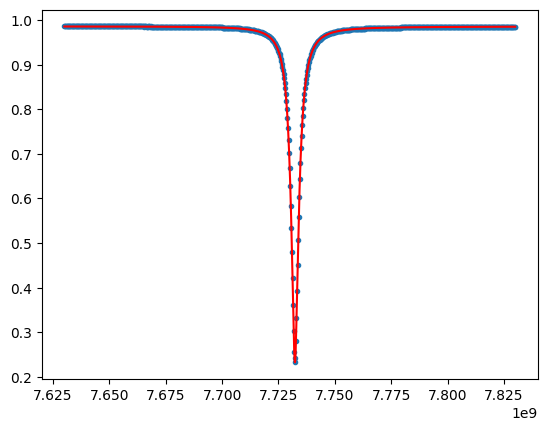

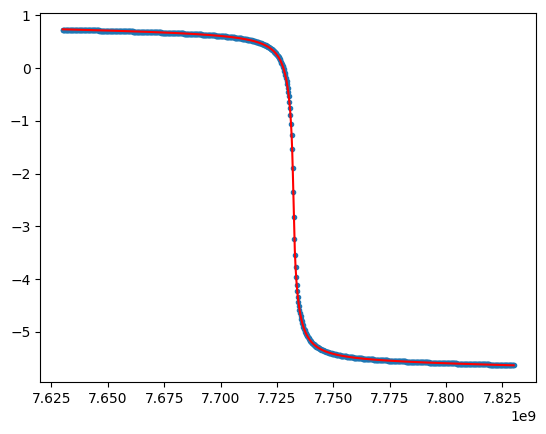

In [79]:

plt.figure()
plt.plot(freq_cut, linmag0, '.')
plt.plot(freq_fit, linmag_fit, 'red')

plt.figure()
plt.plot(freq_cut, uwphase0, '.')
plt.plot(freq_fit, uwphase_fit, 'red')